# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables.

In [2]:
import pandas as pd

data = pd.read_csv("DataSet.csv", sep=';', index_col="ind")

print(data)

     EECC TipoEC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  \
ind                                                                          
1    BL09   MAEF        1  32458  146916  220.94       3       127   4.697   
2    BL09   MAEF        2  39967  150917  264.84       3       127   4.697   
3    BL09   MAEF        3  39438  145916  270.29       3       127   4.697   
4    BL09   MAEF        4  30342  145930  207.93       3       127   4.697   
5    BL09   MAEF        5  30361  140921  215.46       3       127   4.697   
..    ...    ...      ...    ...     ...     ...     ...       ...     ...   
142  BL15   MAEF        4  37083  140926  263.14       3       127   4.700   
143  BL21   MAEF        1  39939  142930  279.44       2       146   4.665   
144  BL21   MAEF        2  45292  143926  314.70       2       146   4.665   
145  BL21   MAEF        3  47127  144925  325.20       2       146   4.665   
146  BL21   MAEF        4  39936  142928  279.41       2       1

### Codificación de la categoría TipoEC

In [3]:
data.TipoEC.value_counts()

MAEF    86
STD     32
AEF     20
OFA      8
Name: TipoEC, dtype: int64

In [4]:
dummies = pd.get_dummies(data['TipoEC'])
data = pd.concat([data, dummies], axis = 1)
data = data.drop(columns=['TipoEC'])
print (data)

     EECC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU  \
ind                                                                            
1    BL09        1  32458  146916  220.94       3       127   4.697    44082   
2    BL09        2  39967  150917  264.84       3       127   4.697    46265   
3    BL09        3  39438  145916  270.29       3       127   4.697    46517   
4    BL09        4  30342  145930  207.93       3       127   4.697    43374   
5    BL09        5  30361  140921  215.46       3       127   4.697    43788   
..    ...      ...    ...     ...     ...     ...       ...     ...      ...   
142  BL15        4  37083  140926  263.14       3       127   4.700    46187   
143  BL21        1  39939  142930  279.44       2       146   4.665    47227   
144  BL21        2  45292  143926  314.70       2       146   4.665    48747   
145  BL21        3  47127  144925  325.20       2       146   4.665    49176   
146  BL21        4  39936  142928  279.4

### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [5]:
data = data [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
print(data)

     EECC  Muestra  MAEF  OFA  STD   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU
ind                                                                          
1    BL09        1     1    0    0  220.94       3       127   4.697    44082
2    BL09        2     1    0    0  264.84       3       127   4.697    46265
3    BL09        3     1    0    0  270.29       3       127   4.697    46517
4    BL09        4     1    0    0  207.93       3       127   4.697    43374
5    BL09        5     1    0    0  215.46       3       127   4.697    43788
..    ...      ...   ...  ...  ...     ...     ...       ...     ...      ...
142  BL15        4     1    0    0  263.14       3       127   4.700    46187
143  BL21        1     1    0    0  279.44       2       146   4.665    47227
144  BL21        2     1    0    0  314.70       2       146   4.665    48747
145  BL21        3     1    0    0  325.20       2       146   4.665    49176
146  BL21        4     1    0    0  279.41       2       146   4

### Normalización y discretización de los datos

In [6]:
import numpy as np

tipoMaef = np.array(data.values[:,2], dtype='float')
tipoOfa = np.array(data.values[:,3], dtype='float')
tipoStd = np.array(data.values[:,4], dtype='float')
cuentasSeg = np.array(data.values[:,5], dtype='float')
ciclos = np.array(data.values[:,6], dtype='float')
enfri = np.array(data.values[:,7], dtype='float')
enriq = np.array(data.values[:,8], dtype='float')
QUEMADO = np.array(data.values[:,9], dtype='float')

from scipy import stats
cuentasSegNorm = stats.zscore(cuentasSeg)
ciclosNorm = stats.zscore(ciclos)
enfriNorm = stats.zscore(enfri)
enriqNorm = stats.zscore(enriq)
QUEMADOnorm = stats.zscore(QUEMADO)


from sklearn.preprocessing import KBinsDiscretizer
###################################################################################################
# Elegimos el número de intervalos según las modas en la distribución (ver histogramas más abajo) #
# Sería mejor utilizar 'uniform' o 'quantile' en lugar de usar 'kmeans' ¿?                        #
###################################################################################################
cuentasSegDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Cnn/s']])
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Enr(%)']])
QUEMADOdis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Mwd/TnU']])

cuentasSegDis = pd.DataFrame(cuentasSegDis)
enfriDis = pd.DataFrame(enfriDis)
enriqDis = pd.DataFrame(enriqDis)
QUEMADOdis = pd.DataFrame(QUEMADOdis)

### Creo un DataFrame con los arrays normalizados y discretos

In [7]:
data = pd.DataFrame({'EECC': data['EECC'], 'Muestra': data['Muestra'], 'MAEF': tipoMaef, \
                     'OFA': tipoOfa, 'STD': tipoStd, 'Cnn/s': cuentasSegNorm, 'Ciclos': ciclosNorm, \
                     'Enf(mes)': enfriNorm, 'Enr(%)': enriqNorm, 'Mwd/TnU': QUEMADOnorm, \
                     'Cnn/s_D': cuentasSegDis.values[:,0], 'Ciclos_D': ciclos, 'Enf(mes)_D': enfriDis.values[:,0], \
                     'Enr(%)_D': enriqDis.values[:,0], 'Mwd/TnU_D': QUEMADOdis.values[:,0]})

print(data)

     EECC  Muestra  MAEF  OFA  STD     Cnn/s    Ciclos  Enf(mes)    Enr(%)  \
ind                                                                          
1    BL09        1   1.0  0.0  0.0 -0.103873  0.536875 -0.602062  0.871258   
2    BL09        2   1.0  0.0  0.0  0.218885  0.536875 -0.602062  0.871258   
3    BL09        3   1.0  0.0  0.0  0.258954  0.536875 -0.602062  0.871258   
4    BL09        4   1.0  0.0  0.0 -0.199524  0.536875 -0.602062  0.871258   
5    BL09        5   1.0  0.0  0.0 -0.144162  0.536875 -0.602062  0.871258   
..    ...      ...   ...  ...  ...       ...       ...       ...       ...   
142  BL15        4   1.0  0.0  0.0  0.206386  0.536875 -0.602062  0.874454   
143  BL21        1   1.0  0.0  0.0  0.326226 -0.862836 -0.424691  0.837169   
144  BL21        2   1.0  0.0  0.0  0.585461 -0.862836 -0.424691  0.837169   
145  BL21        3   1.0  0.0  0.0  0.662658 -0.862836 -0.424691  0.837169   
146  BL21        4   1.0  0.0  0.0  0.326005 -0.862836 -0.424691

### Cálculo de estadísticos

In [8]:
from scipy.stats import iqr

medias = np.mean(data.values[:,5:10], axis=0)
varianzas = np.var(data.values[:,5:10], axis=0)
medianas = np.median(data.values[:,5:10], axis=0)
intercuartil = iqr(data.values[:,5:10], axis=0)

print ('Medias: ', medias)
print ('Varianzas: ', varianzas)
print ('Medianas: ', medianas)
print ('Distancia intercuartil: ', intercuartil)

Medias:  [2.6234722157238288e-17 1.7793985463170317e-16 -6.691755216918751e-17
 -4.395266494748907e-16 1.5816875967262503e-16]
Varianzas:  [1.0000000000000004 0.9999999999999994 1.0000000000000007
 1.0000000000000018 0.9999999999999998]
Medianas:  [-0.009949516200137608 0.5368754921931596 -0.2473210530770556
 0.6187894885156648 0.2488837009800024]
Distancia intercuartil:  [1.8396259145255103 1.399711104646451 1.857721270967109 1.3475642702806132
 1.5921684196786834]


### Diagramas de cajas e histogramas

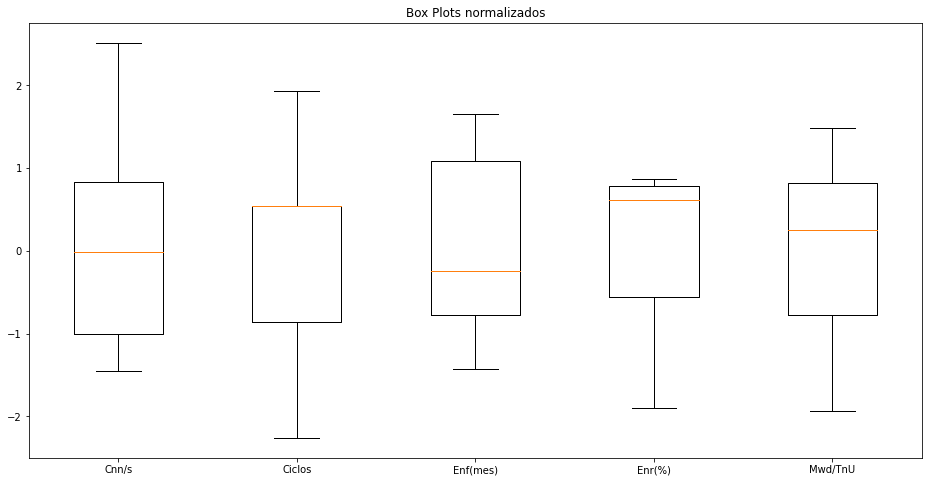

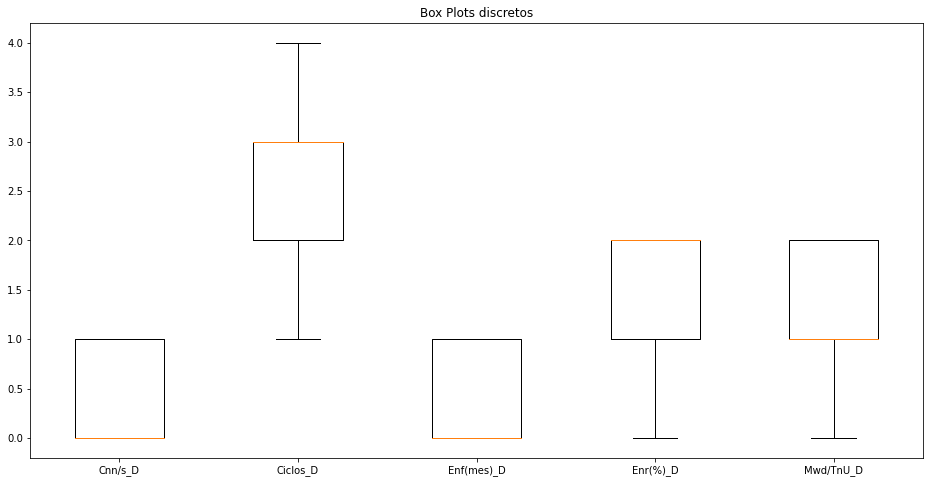

In [9]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plots normalizados')
ax1.boxplot(data.values[:,5:10], labels=data.columns.tolist()[5:10])
plt.show()

fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_title('Box Plots discretos')
ax2.boxplot(data.values[:,10:], labels=data.columns.tolist()[10:])
plt.show()

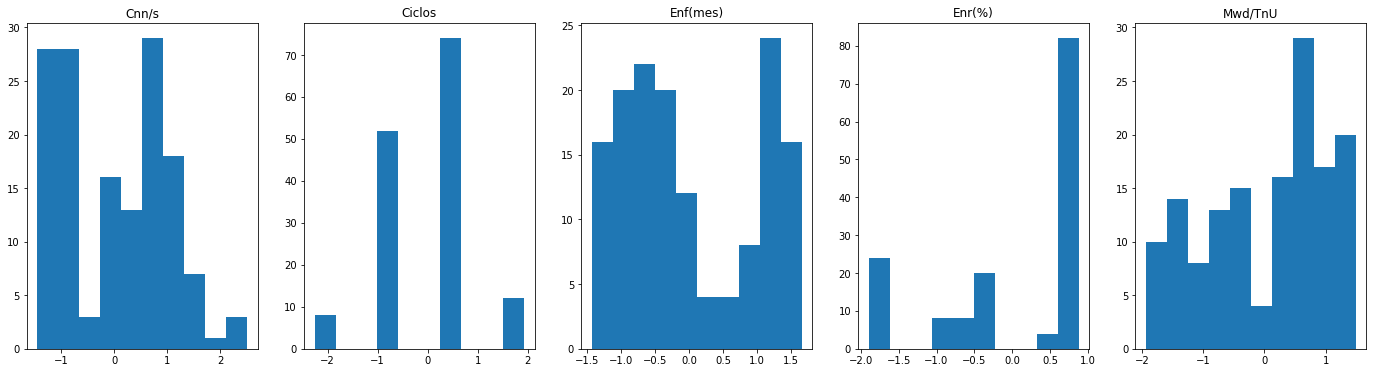

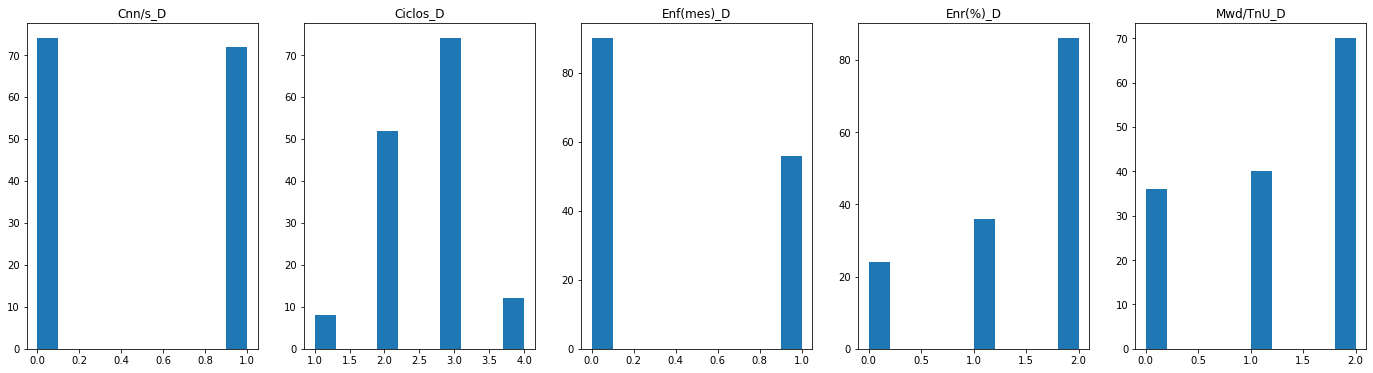

In [10]:
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))

variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax3[a].hist(data[var].values)
    ax3[a].set_title(var)
    a+1
plt.show()


fig4,ax4 = plt.subplots(1,5,figsize=(24,6))

variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax4[a].hist(data[var].values)
    ax4[a].set_title(var)
    a+1
plt.show()

### ScatterPlot de las cuentas neutrónicas por segundo respecto al quemado

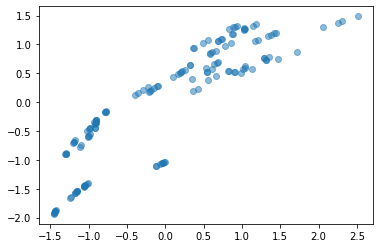

In [22]:
plt.scatter(data['Cnn/s'], data['Mwd/TnU'], alpha=0.5)
plt.show()

Se ve correlación lineal entre las cuentas neutrónicas y el quemado. Parece que hay varias tendencias lineales.


### Coeficiente de correlación

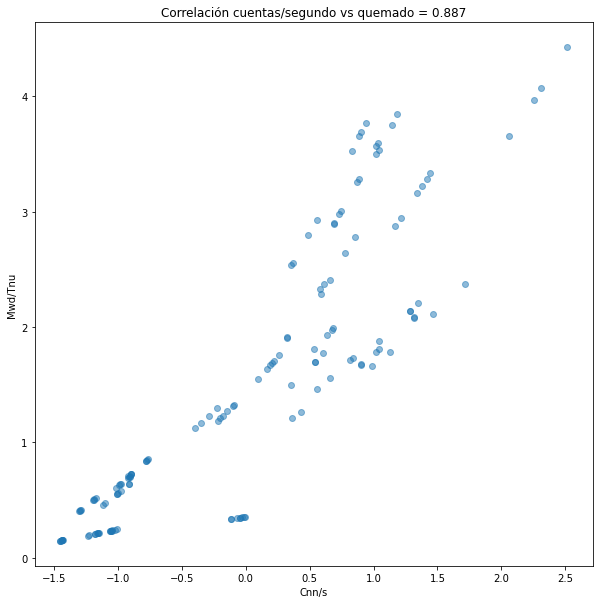

In [23]:
indep = data['Cnn/s'].values
dep = np.exp(data['Mwd/TnU'].values)

corrcoef = np.corrcoef(indep,dep)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(indep,dep, 'o', alpha=0.5)
ax.set_title('Correlación cuentas/segundo vs quemado = {:.3f}'.format(corrcoef[0,1]))
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
plt.show()
plt.close()

### Separo un elemento para validar

In [24]:
excluido = data.at[40, 'EECC']
print(excluido)

agrupa = data.groupby(data.EECC)
val = agrupa.get_group(excluido)
val = np.mean(val.values[:,5:10], axis=0)
print(val)

ent = data[data.EECC != excluido]
print(ent)

BH08
[0.8337967006541347 0.5368754921931594 -0.19130935646498196
 0.6901624577716341 1.1544972695743643]
     EECC  Muestra  MAEF  OFA  STD     Cnn/s    Ciclos  Enf(mes)    Enr(%)  \
ind                                                                          
1    BL09        1   1.0  0.0  0.0 -0.103873  0.536875 -0.602062  0.871258   
2    BL09        2   1.0  0.0  0.0  0.218885  0.536875 -0.602062  0.871258   
3    BL09        3   1.0  0.0  0.0  0.258954  0.536875 -0.602062  0.871258   
4    BL09        4   1.0  0.0  0.0 -0.199524  0.536875 -0.602062  0.871258   
5    BL09        5   1.0  0.0  0.0 -0.144162  0.536875 -0.602062  0.871258   
..    ...      ...   ...  ...  ...       ...       ...       ...       ...   
142  BL15        4   1.0  0.0  0.0  0.206386  0.536875 -0.602062  0.874454   
143  BL21        1   1.0  0.0  0.0  0.326226 -0.862836 -0.424691  0.837169   
144  BL21        2   1.0  0.0  0.0  0.585461 -0.862836 -0.424691  0.837169   
145  BL21        3   1.0  0.0  0.0  0

# PENDIENTE HACER ITERACIÓN PARA HACER CROOS VALIDATION

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

In [27]:
# Incluyo término independiente
X = np.array([np.ones(ent['Cnn/s'].shape[0]), ent['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ np.exp(ent['Mwd/TnU'])

print(B)

[1.45304596 0.98964197]


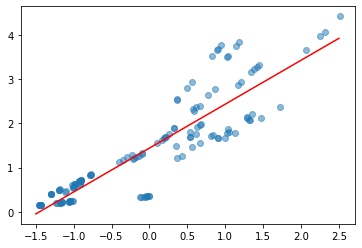

In [28]:
# La gráfica incluyendo la línea de regresión
plt.scatter(ent['Cnn/s'], np.exp(ent['Mwd/TnU']), alpha=0.5)
plt.plot([-1.5, 2.5], [B[0]-1.5, B[0]+B[1]*2.5], c='red')
plt.show()

### Correlación separando por colores según las demás variables

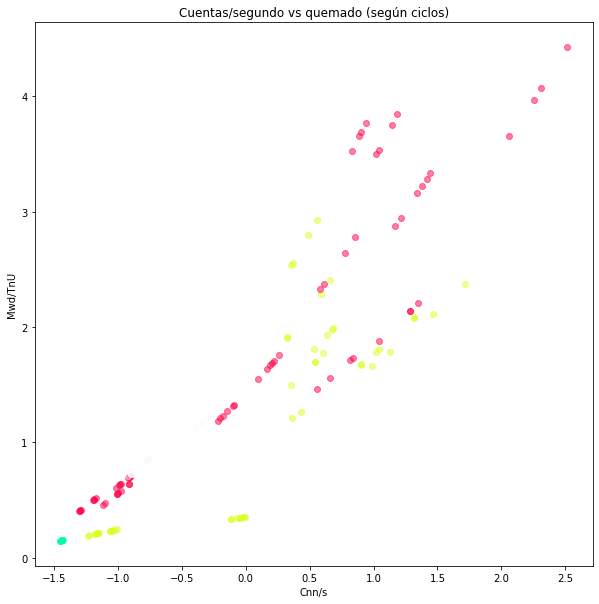

In [29]:
import matplotlib

cmap = matplotlib.cm.get_cmap('gist_ncar')

fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(ent['Ciclos_D'].values))

for i in range(colores+1):
    indep = ent['Cnn/s'].loc[ent['Ciclos_D']==i].values
    dep = np.exp(ent['Mwd/TnU']).loc[ent['Ciclos_D']==i].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según ciclos)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
plt.close()

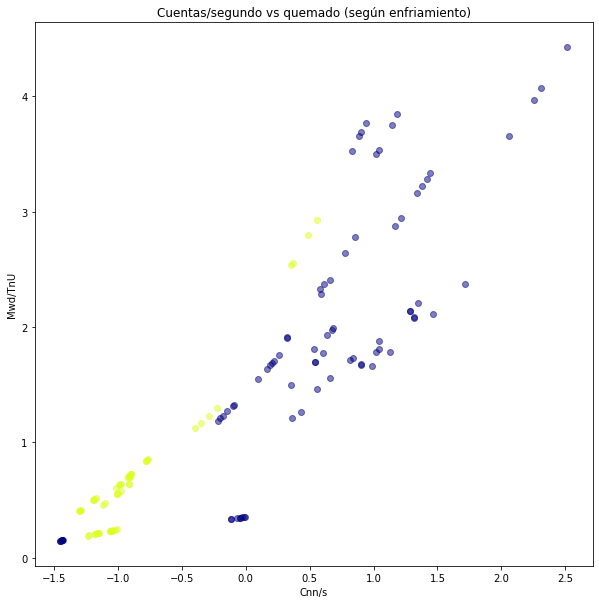

In [30]:
fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(ent['Enf(mes)_D'].values)+1)

for i in range(colores+1):
    indep = ent['Cnn/s'].loc[ent['Enf(mes)_D']==i].values
    dep = np.exp(ent['Mwd/TnU']).loc[ent['Enf(mes)_D']==i].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según enfriamiento)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
plt.close()

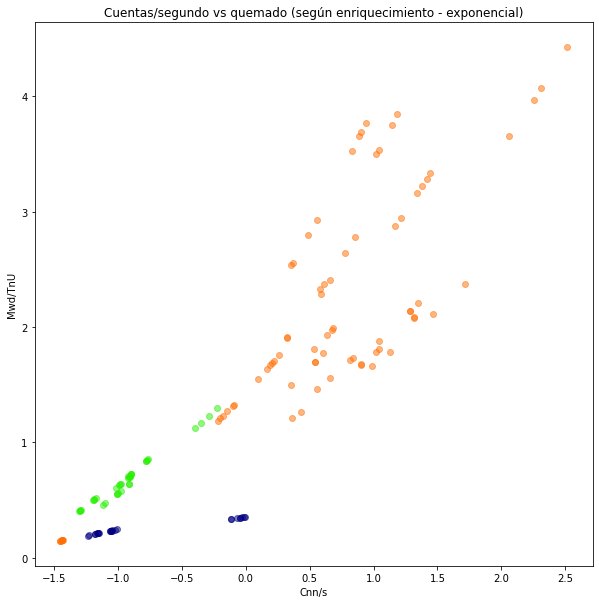

In [31]:
fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(ent['Enr(%)_D'].values)+1)

for i in range(colores+1):
    indep = ent['Cnn/s'].loc[ent['Enr(%)_D']==i].values
    dep = np.exp(ent['Mwd/TnU']).loc[ent['Enr(%)_D']==i].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según enriquecimiento - exponencial)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
    
plt.close()

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [32]:
X = np.array([np.ones(ent['Cnn/s'].shape[0]), ent['Cnn/s'], ent['Ciclos'], ent['Enf(mes)'], ent['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ np.exp(ent['Mwd/TnU'])

print(B)

[ 1.47213987  1.17554483 -0.17940049  0.76222701  0.60348343]


Ahora se supone entonces que: $Mwd/Tnu = B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

In [34]:
calc = B[0]+B[1]*val[0]+B[2]*val[1]+B[3]*val[2]+B[4]*val[3]
sol = np.exp(val[4])
dif = ((calc - sol)/sol)*100

print('Diferencia de', '{0:.2f}'.format(dif), '%')

Diferencia de -17.20 %


### ¿?¿? LA RELACIÓN PODRÍA SER LOGARÍTMICA EN LUGAR DE LINEAL ¿?¿?